# 1. Install Dependencies and Setup

In [1]:
%pip list
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
import tensorflow as tf
import os

Package                      VersionNote: you may need to restart the kernel to use updated packages.

---------------------------- -----------
absl-py                      1.2.0
altair                       4.2.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.2
asttokens                    2.0.5
astunparse                   1.6.3
attrs                        21.4.0
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       5.0.1
blinker                      1.5
cachetools                   5.2.0
certifi                      2022.9.24
cffi                         1.15.1
charset-normalizer           2.1.1
click                        8.1.3
colorama                     0.4.5
commonmark                   0.9.1
contourpy                    1.0.5
cycler                       0.11.0
DateTime                     4.7
debugpy                      1.6.2
decorator                    5.1.1
defusedxml

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'I:/College/image-classifier/class/train' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('I:/College/image-classifier/class/train')

Found 5119 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()


In [11]:
# batch = data_iterator.next()
batch = [ next(data_iterator) for i in range(5) ]



TypeError: Invalid shape (32, 256, 256, 3) for image data

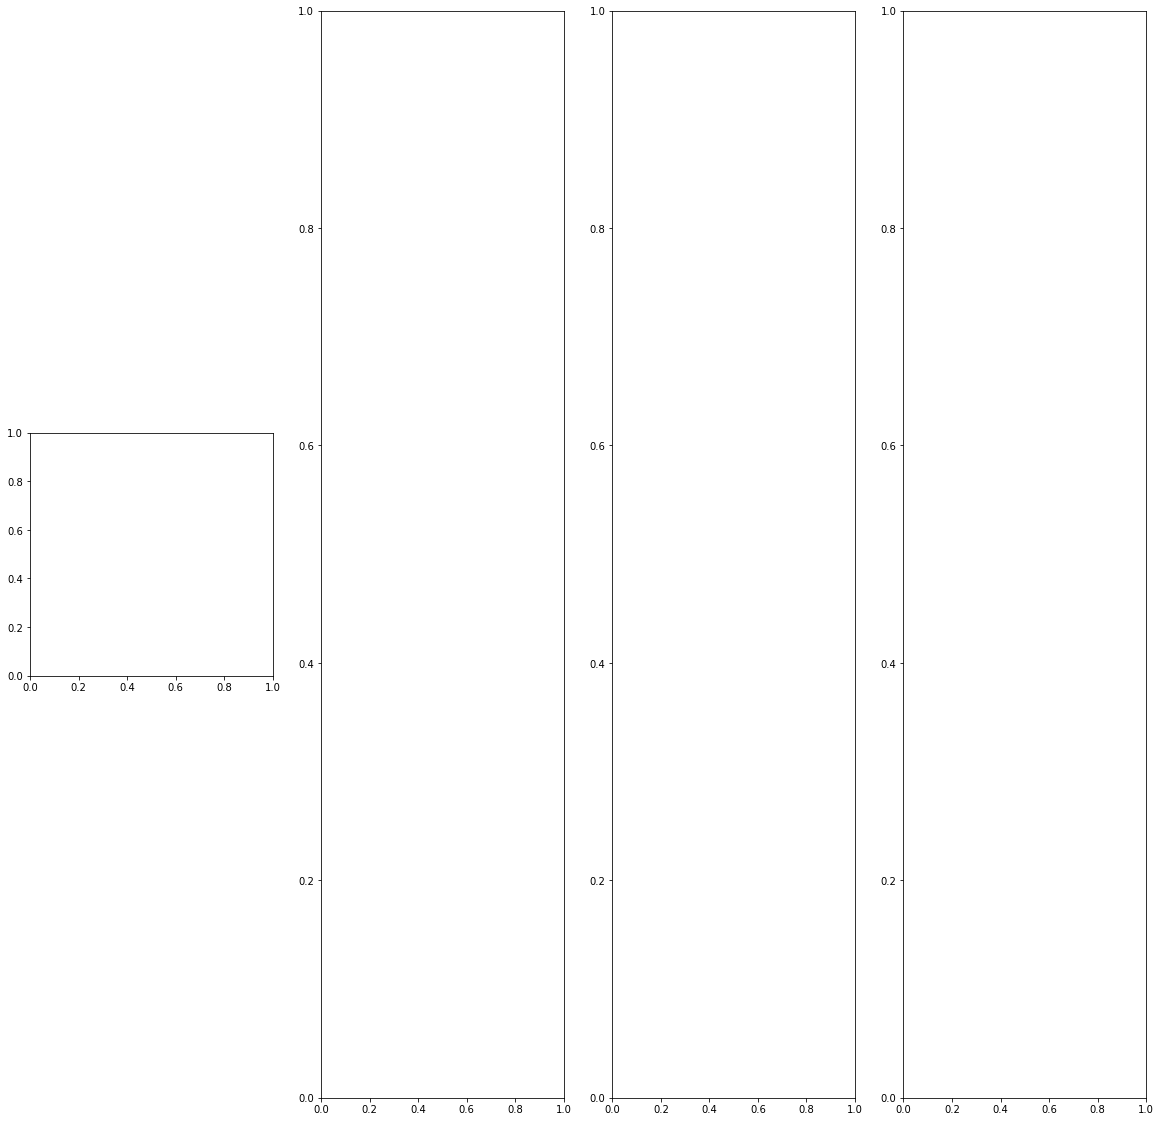

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))
len(data)

160

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.229894  , 0.27695283, 0.08461214],
          [0.18560684, 0.23148744, 0.05834231],
          [0.17418231, 0.22032967, 0.0812555 ],
          ...,
          [0.37705246, 0.48501813, 0.22261006],
          [0.19593392, 0.26715022, 0.06282666],
          [0.15006253, 0.21734661, 0.01726236]],
 
         [[0.26369905, 0.31429645, 0.12203871],
          [0.1639792 , 0.21550143, 0.03181158],
          [0.14956772, 0.20352544, 0.02064724],
          ...,
          [0.40644932, 0.515507  , 0.25091493],
          [0.31463456, 0.39453256, 0.17193758],
          [0.24128155, 0.3155922 , 0.10113077]],
 
         [[0.16766974, 0.22383878, 0.03631251],
          [0.22584139, 0.2845446 , 0.08074335],
          [0.19430913, 0.2603036 , 0.04054613],
          ...,
          [0.37056908, 0.47800627, 0.21778403],
          [0.4074844 , 0.49868384, 0.2688355 ],
          [0.38078028, 0.46683666, 0.24269086]],
 
         ...,
 
         [[0.2832505 , 0.33444902, 0.20089757],
          [0.26425

# 5. Split Data

In [16]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
print(train_size, val_size, test_size)

112 32 16


In [17]:
train_size

112

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
print(test)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# 6. Build Deep Learning Model

In [19]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [25]:
logdir='I:/College/image-classifier/logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=200, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/200
112/112 [==============================] - 320s 3s/step - loss: 0.5659 - accuracy: 0.7107 - val_loss: 0.4328 - val_accuracy: 0.8164
Epoch 2/200
112/112 [==============================] - 303s 3s/step - loss: 0.4106 - accuracy: 0.8105 - val_loss: 0.3687 - val_accuracy: 0.8496
Epoch 3/200
112/112 [==============================] - 315s 3s/step - loss: 0.3184 - accuracy: 0.8566 - val_loss: 0.3249 - val_accuracy: 0.8516
Epoch 4/200
112/112 [==============================] - 284s 3s/step - loss: 0.2441 - accuracy: 0.8945 - val_loss: 0.2983 - val_accuracy: 0.8779
Epoch 5/200
112/112 [==============================] - 312s 3s/step - loss: 0.1838 - accuracy: 0.9272 - val_loss: 0.3302 - val_accuracy: 0.8672
Epoch 6/200
112/112 [==============================] - 286s 3s/step - loss: 0.1361 - accuracy: 0.9484 - val_loss: 0.5015 - val_accuracy: 0.8359
Epoch 7/200
112/112 [==============================] - 312s 3s/step - loss: 0.1071 - accuracy: 0.9584 - val_loss: 0.3499 - val_accuracy:

Epoch 57/200
112/112 [==============================] - 289s 3s/step - loss: 1.0249e-05 - accuracy: 1.0000 - val_loss: 0.9877 - val_accuracy: 0.8975
Epoch 58/200
112/112 [==============================] - 313s 3s/step - loss: 8.8979e-06 - accuracy: 1.0000 - val_loss: 0.9134 - val_accuracy: 0.9014
Epoch 59/200
112/112 [==============================] - 287s 3s/step - loss: 9.2999e-06 - accuracy: 1.0000 - val_loss: 0.8930 - val_accuracy: 0.9033
Epoch 60/200
112/112 [==============================] - 315s 3s/step - loss: 8.1154e-06 - accuracy: 1.0000 - val_loss: 0.9382 - val_accuracy: 0.9023
Epoch 61/200
112/112 [==============================] - 314s 3s/step - loss: 7.4335e-06 - accuracy: 1.0000 - val_loss: 1.0108 - val_accuracy: 0.9014
Epoch 62/200
112/112 [==============================] - 291s 3s/step - loss: 6.9736e-06 - accuracy: 1.0000 - val_loss: 0.9539 - val_accuracy: 0.9004
Epoch 63/200
112/112 [==============================] - 291s 3s/step - loss: 6.5695e-06 - accuracy: 1.0000

112/112 [==============================] - 285s 3s/step - loss: 2.5084e-05 - accuracy: 1.0000 - val_loss: 1.1122 - val_accuracy: 0.8809
Epoch 113/200
112/112 [==============================] - 313s 3s/step - loss: 2.1768e-05 - accuracy: 1.0000 - val_loss: 1.0557 - val_accuracy: 0.8789
Epoch 114/200
112/112 [==============================] - 286s 3s/step - loss: 1.8556e-05 - accuracy: 1.0000 - val_loss: 1.0034 - val_accuracy: 0.8828
Epoch 115/200
112/112 [==============================] - 285s 3s/step - loss: 1.6815e-05 - accuracy: 1.0000 - val_loss: 1.0036 - val_accuracy: 0.8867
Epoch 116/200
112/112 [==============================] - 283s 3s/step - loss: 1.5871e-05 - accuracy: 1.0000 - val_loss: 0.9824 - val_accuracy: 0.8857
Epoch 117/200
112/112 [==============================] - 283s 3s/step - loss: 1.5961e-05 - accuracy: 1.0000 - val_loss: 1.0483 - val_accuracy: 0.8818
Epoch 118/200
112/112 [==============================] - 286s 3s/step - loss: 1.2769e-05 - accuracy: 1.0000 - val_

112/112 [==============================] - 412s 4s/step - loss: 4.1386e-07 - accuracy: 1.0000 - val_loss: 1.3144 - val_accuracy: 0.8818
Epoch 167/200
112/112 [==============================] - 319s 3s/step - loss: 4.0820e-07 - accuracy: 1.0000 - val_loss: 1.4158 - val_accuracy: 0.8770
Epoch 168/200
112/112 [==============================] - 298s 3s/step - loss: 3.6714e-07 - accuracy: 1.0000 - val_loss: 1.2819 - val_accuracy: 0.8877
Epoch 169/200
112/112 [==============================] - 319s 3s/step - loss: 4.2735e-07 - accuracy: 1.0000 - val_loss: 1.5230 - val_accuracy: 0.8760
Epoch 170/200
112/112 [==============================] - 318s 3s/step - loss: 3.3245e-07 - accuracy: 1.0000 - val_loss: 1.3724 - val_accuracy: 0.8809
Epoch 171/200
112/112 [==============================] - 291s 3s/step - loss: 3.1091e-07 - accuracy: 1.0000 - val_loss: 1.4225 - val_accuracy: 0.8809
Epoch 172/200
112/112 [==============================] - 441s 4s/step - loss: 3.1539e-07 - accuracy: 1.0000 - val_

# 8. Plot Performance

160/160 [==============================] - 108s 661ms/step


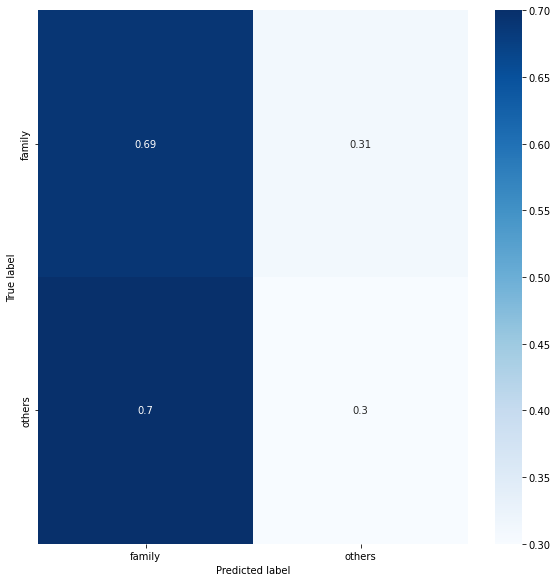

In [28]:
# %pip install seaborn 

import pandas as pd
import seaborn as sns

classes =["family", "others"] 
y_true = np.concatenate([y for x, y in data], axis=0) 
y_pred = model.predict(data)

con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)


figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

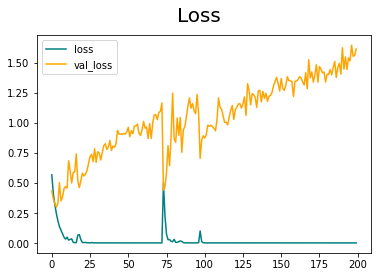

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

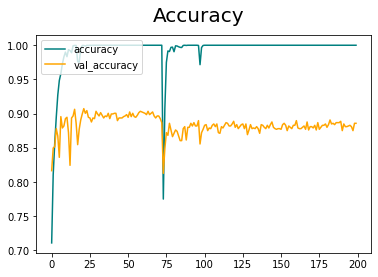

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 649ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.85393256, shape=(), dtype=float32) tf.Tensor(0.8, shape=(), dtype=float32) tf.Tensor(0.8747554, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

In [1]:
img = cv2.imread('I:/College/image-classifier/class/test/others/1-2.jpg')
plt.imshow(img)
plt.show()

NameError: name 'cv2' is not defined

In [4]:
yhat = model.predict(np.expand_dims(resize/255, 0))

NameError: name 'model' is not defined

In [3]:
yhat

NameError: name 'yhat' is not defined

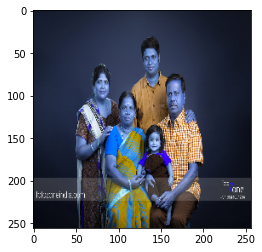

Predicted class is Others


In [62]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

if (yhat).any() > 0.5: 
    print(f'Predicted class is Others')
else:
    print(f'Predicted class is Family')

# 11. Save the Model

In [50]:
from tensorflow.keras.models import load_model

In [51]:
import os
model.save(os.path.join('models','I:/College/Classifier/models/imageclassifier-30-10.h5'))

In [54]:
new_model = load_model('I:/College/Classifier/models/imageclassifier-30-10.h5')

In [55]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 186ms/step


array([[1.]], dtype=float32)